<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/RNN%20With%20IMDB%20%26%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Train a recurrent neural network (RNN) for sentiment classification 
* This notebook is largely based on the [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Cholle

### Import Libraries


```
First, the needed imports. 
Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.
```


In [15]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.2.4 backend: tensorflow


### Load IMDB Dataset

```
Load the IMDB dataset 
The dataset contains 50000 movies reviews from the Internet Movie Database

Split into 25000 reviews for training and 25000 reviews for testing
Half of the reviews are positive (1) and half are negative (0)

The dataset has already been preprocessed,
and each word has been replaced by an integer index. 

The reviews are thus represented as varying-length sequences of integers. 
(Word indices begin at "3":
      - "1" is used to mark the start of a review 
      - "2" represents all out-of-vocabulary words
      - "0" will be used later to pad shorter reviews to a fixed size.)
```

In [17]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 3s 0us/step
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


* The first movie review in the training set:

In [18]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

### Initialization

```
Create an RNN model that has one (or optionally two) LSTM layers:

The first layer in the network is an Embedding layer that converts integer indices to dense vectors of length embedding_dims. 

The output layer contains a single neuron and sigmoid non-linearity to match the binary groundtruth (y_train). 

Finally, compile() the model, using binary crossentropy as the loss function and RMSprop  as the optimizer.
```

In [19]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# model.add(LSTM(lstm_units))
# running on a GPU:
model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________
None


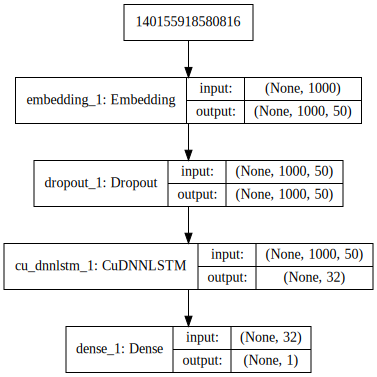

In [20]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train the Model


```
Using a fraction of the training data as our validation set.
p.s. LSTMs are rather slow to train.
```



In [21]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 36s 2ms/step - loss: 0.4927 - acc: 0.7611 - val_loss: 0.3682 - val_acc: 0.8452
Epoch 2/5
20000/20000 [==============================] - 33s 2ms/step - loss: 0.3051 - acc: 0.8768 - val_loss: 0.3005 - val_acc: 0.8766
Epoch 3/5
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2537 - acc: 0.9004 - val_loss: 0.3123 - val_acc: 0.8870
Epoch 4/5
20000/20000 [==============================] - 18s 903us/step - loss: 0.2173 - acc: 0.9188 - val_loss: 0.2912 - val_acc: 0.8784
Epoch 5/5
20000/20000 [==============================] - 17s 841us/step - loss: 0.1905 - acc: 0.9310 - val_loss: 0.2952 - val_acc: 0.8794
CPU times: user 1min 27s, sys: 25.6 s, total: 1min 53s
Wall time: 2min 17s


* Plot the data to see how the training progressed. 

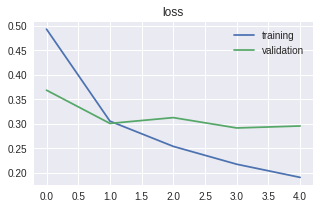

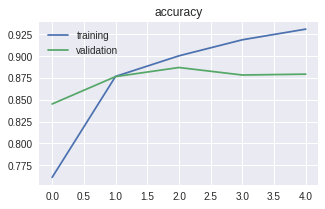

In [22]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

A big gap between training and validation accuracies would suggest overfitting.

### Prediction & Confusion Matrix



```
Run predictions for test set
```

In [23]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

Accuracy: 87.40%
Test score: 30.93%




```
Check the confusion matrix to see the accuracy, precision, recall and misclassifications 
```



0.87396
              precision    recall  f1-score   support

         pos       0.89      0.86      0.87     12500
         neg       0.86      0.89      0.88     12500

   micro avg       0.87      0.87      0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

[[10691  1809]
 [ 1342 11158]]


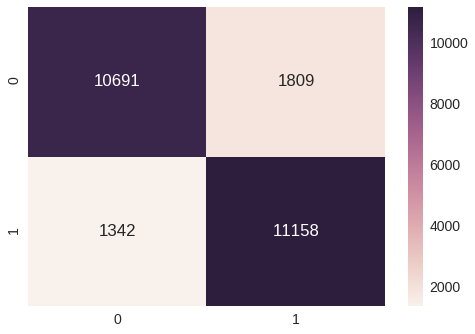

In [24]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')




```
According to the confusion matrix:
10230 positive reviews were correctly predicted (True Positive) 
10058 negative samples were correctly predicted (True Negative)
Number of incorrect predictions are 2270 (False Positive) and 2442 (False Negative).
```



In [25]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.12604




```

```



### Transfer Model

In [0]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import itertools
import os

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.layers import LSTM, CuDNNLSTM

from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.callbacks import EarlyStopping

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
sns.set()

In [0]:
ls

In [26]:
financial_data = pd.read_csv('cleanedfinancial_data.csv')
financial_data.drop(columns="Unnamed: 0", inplace=True)

financial_data.iloc[2,1]

"Well, we need to bring the Shanghai factory online. I think that's the biggest driver for getting to 500K plus a year. Our car is just very expensive going into China. We've got import duties. We've got transport costs. We've got higher-cost labor here. And we've never been eligible for any of the EV tax credits. A lot of people sort of dependent on incentives. In fact, we are [indiscernible] EVs, we have the least access to incentives. It's pretty crazy because there's so many companies that - countries that have put price caps on the EV incentive, which affects Tesla. And in China, which is the biggest market for EVs, we've never had any subsidies or tax incentives for vehicles."

In [27]:
financial_test = financial_data[financial_data['sentiment'] != 'neutral']
financial_test['sentiment'] = financial_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
tokenizer = Tokenizer(num_words=1000)

financial_x_test = tokenizer.texts_to_matrix(financial_test['text'].tolist(), mode='freq')
financial_y_test = np.asarray(financial_test['sentiment'])

In [32]:
score, acc = model.evaluate(financial_x_test, financial_y_test, verbose=1)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

811/811 [==============================] - 1s 2ms/step
Accuracy: 80.64%
Test score: 60.56%


0.8064118372379778
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00       157
         neg       0.81      1.00      0.89       654

   micro avg       0.81      0.81      0.81       811
   macro avg       0.40      0.50      0.45       811
weighted avg       0.65      0.81      0.72       811

[[  0 157]
 [  0 654]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


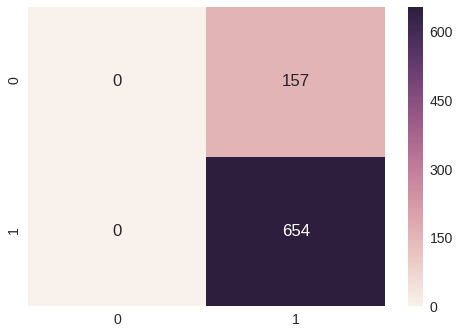

In [33]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(financial_x_test))

from sklearn import metrics
print(metrics.accuracy_score(financial_y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(financial_y_test, y_pred)

print(classification_report(financial_y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')

In [34]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.1935881627620222
